### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

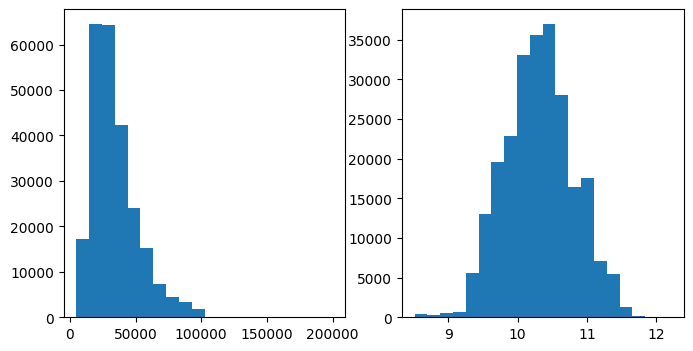

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
59193,68690240,Learning Development Manager 6 month contract...,Learning Development Manager 6 month contract...,London South East,South East London,NaN,contract,Hamilton Mayday,HR & Recruitment Jobs,17 - 20 per hour,35520,totaljobs.com,10.477880
173429,71430578,Site Manager,My client are looking for a Contract Site Mana...,"Rainham, Essex Essex South East",UK,NaN,permanent,Engineering Services Bureau Ltd,Other/General Jobs,From 250 to 320 per day fully inclusive,68400,totaljobs.com,11.133142
154739,71016793,Legal Secretary/Personal Assistant (PA) Litig...,Career Legal – Specialists in Legal Secretaria...,London,London,full_time,permanent,Career Legal Sec Perm,Legal Jobs,"From 34,000 to 36,000 per year",35000,TotallyLegal,10.463132


In [5]:
import nltk

data["Title"].fillna("")
data["FullDescription"].fillna("")

tokenizer = nltk.tokenize.WordPunctTokenizer()

data["FullDescription"] = data["FullDescription"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data["Title"] = data["Title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for line in data["Title"].values:
    token_counts.update(line.split(' '))

for line in data["FullDescription"].values:
    token_counts.update(line.split(' '))

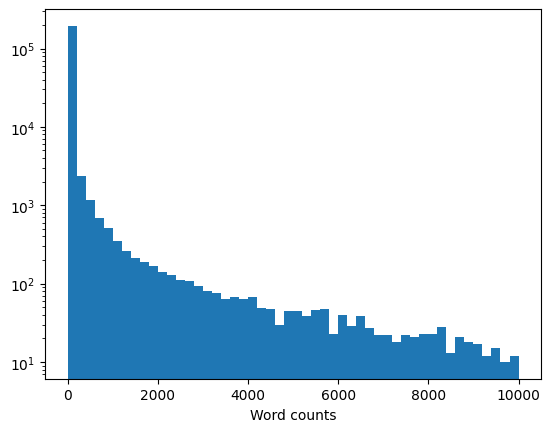

In [7]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [8]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [9]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [10]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [11]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [12]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...

In [15]:
embed_len = 300

class EncoderCNN(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embed_len)
        self.conv1 = nn.Conv1d(embed_len, hid_size, kernel_size=(3,))
        self.conv2 = nn.Conv1d(embed_len, hid_size, kernel_size=(2,))

    def forward(self, matrix):
        emb1 = self.conv1(self.emb(matrix).swapaxes(1, 2)).max(dim=-1).values
        emb2 = self.conv2(self.emb(matrix).swapaxes(1, 2)).max(dim=-1).values

        return torch.cat((emb1, emb2), 1)
        #return emb1

In [16]:
class SalaryPredictorCNN(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderCNN(n_tokens, hid_size)
        self.description_enc = EncoderCNN(n_tokens, hid_size)
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.fc1 = nn.Linear(5 * hid_size, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return torch.squeeze(x)

In [17]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

In [18]:
from tqdm.auto import tqdm

BATCH_SIZE = 20
EPOCHS = 10

In [19]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN = SalaryPredictorCNN().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=1e-4)

mse_loss = []
mae_loss = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_CNN.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_CNN(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_CNN, data_val, device=device)
    mse_loss.append(mse)
    mae_loss.append(mae)


epoch: 0


9791it [01:47, 90.68it/s]                          


 results:
Mean square error: 0.12824
Mean absolute error: 0.27205
epoch: 1


9791it [01:47, 91.34it/s]                          


 results:
Mean square error: 0.10824
Mean absolute error: 0.25506
epoch: 2


9791it [01:48, 90.44it/s]                          


 results:
Mean square error: 0.09111
Mean absolute error: 0.22695
epoch: 3


9791it [01:48, 89.88it/s]                          


 results:
Mean square error: 0.08374
Mean absolute error: 0.21900
epoch: 4


9791it [01:46, 91.94it/s]                          


 results:
Mean square error: 0.07564
Mean absolute error: 0.20478
epoch: 5


9791it [01:46, 91.63it/s]                          


 results:
Mean square error: 0.08276
Mean absolute error: 0.21699
epoch: 6


9791it [01:46, 91.68it/s]                          


 results:
Mean square error: 0.09170
Mean absolute error: 0.23165
epoch: 7


9791it [01:47, 90.70it/s]                          


 results:
Mean square error: 0.07033
Mean absolute error: 0.19701
epoch: 8


9791it [01:49, 89.24it/s]                          


 results:
Mean square error: 0.07137
Mean absolute error: 0.19869
epoch: 9


9791it [01:47, 90.68it/s]                          


 results:
Mean square error: 0.06764
Mean absolute error: 0.19327


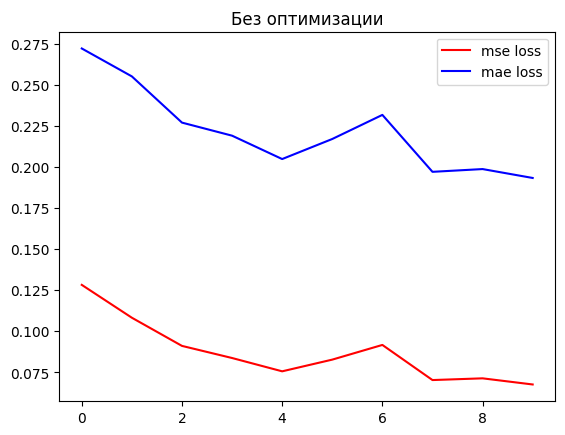

In [27]:
plt.plot(np.array(mse_loss), color='r', label='mse loss'), plt.plot(np.array(mae_loss), color='b', label='mae loss')
plt.legend()
plt.title('Без оптимизации')
plt.show()

In [28]:
class SalaryPredictorCNNBatchNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderCNN(n_tokens, hid_size)
        self.description_enc = EncoderCNN(n_tokens, hid_size)
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.model = nn.Sequential(
            nn.Linear(5 * hid_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.model(x)

        return torch.squeeze(x)

In [29]:
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN_modified = SalaryPredictorCNNBatchNorm().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_CNN_modified.parameters(), lr=1e-4)

mse_loss_cnn_modified = []
mae_loss_cnn_modified = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_CNN_modified.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_CNN_modified(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_CNN_modified, data_val, device=device)
    mse_loss_cnn_modified.append(mse)
    mae_loss_cnn_modified.append(mae)


epoch: 0


9791it [01:51, 88.04it/s]                          


 results:
Mean square error: 0.17258
Mean absolute error: 0.32158
epoch: 1


9791it [01:51, 88.08it/s]                          


 results:
Mean square error: 0.15706
Mean absolute error: 0.31117
epoch: 2


9791it [01:51, 87.82it/s]                          


 results:
Mean square error: 0.11038
Mean absolute error: 0.25304
epoch: 3


9791it [01:49, 89.49it/s]                          


 results:
Mean square error: 0.11196
Mean absolute error: 0.25750
epoch: 4


9791it [01:49, 89.16it/s]                          


 results:
Mean square error: 0.10178
Mean absolute error: 0.24414
epoch: 5


9791it [01:48, 89.88it/s]                          


 results:
Mean square error: 0.10344
Mean absolute error: 0.24598
epoch: 6


9791it [01:53, 86.54it/s]                          


 results:
Mean square error: 0.09292
Mean absolute error: 0.23177
epoch: 7


9791it [01:52, 86.66it/s]                          


 results:
Mean square error: 0.09986
Mean absolute error: 0.24286
epoch: 8


9791it [01:52, 87.26it/s]                          


 results:
Mean square error: 0.09918
Mean absolute error: 0.24265
epoch: 9


9791it [01:49, 89.41it/s]                          


 results:
Mean square error: 0.10677
Mean absolute error: 0.25489


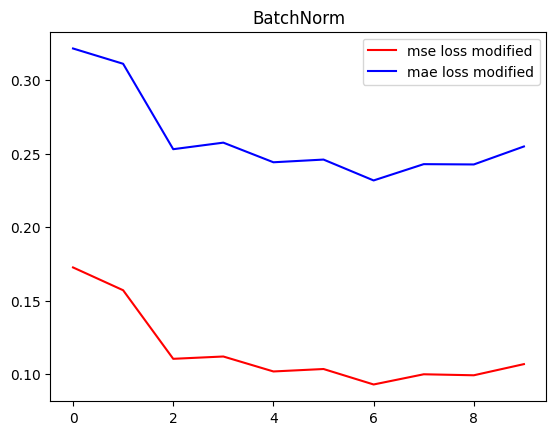

In [30]:
plt.plot(np.array(mse_loss_cnn_modified), color='r', label='mse loss modified')
plt.plot(np.array(mae_loss_cnn_modified), color='b', label='mae loss modified')
plt.legend()
plt.title('BatchNorm')
plt.show()

In [31]:
class SalaryPredictorCNNwithDropout(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderCNN(n_tokens, hid_size)
        self.description_enc = EncoderCNN(n_tokens, hid_size)
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.model = nn.Sequential(
            nn.Linear(5 * hid_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.model(x)

        return torch.squeeze(x)

In [32]:
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN_with_dropout= SalaryPredictorCNNwithDropout().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_CNN_with_dropout.parameters(), lr=1e-4)

mse_loss_cnn_with_dropout = []
mae_loss_cnn_with_dropout = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_CNN_with_dropout.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_CNN_with_dropout(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_CNN_with_dropout, data_val, device=device)
    mse_loss_cnn_with_dropout.append(mse)
    mae_loss_cnn_with_dropout.append(mae)


epoch: 0


9791it [01:50, 88.78it/s]                          


 results:
Mean square error: 0.20753
Mean absolute error: 0.35579
epoch: 1


9791it [01:51, 88.21it/s]                          


 results:
Mean square error: 0.15986
Mean absolute error: 0.31103
epoch: 2


9791it [01:48, 89.84it/s]                          


 results:
Mean square error: 0.13962
Mean absolute error: 0.28865
epoch: 3


9791it [01:50, 88.66it/s]                          


 results:
Mean square error: 0.11787
Mean absolute error: 0.26208
epoch: 4


9791it [01:53, 85.91it/s]                          


 results:
Mean square error: 0.09462
Mean absolute error: 0.22995
epoch: 5


9791it [01:51, 87.80it/s]                          


 results:
Mean square error: 0.09470
Mean absolute error: 0.23070
epoch: 6


9791it [01:51, 87.91it/s]                          


 results:
Mean square error: 0.08851
Mean absolute error: 0.22207
epoch: 7


9791it [01:49, 89.36it/s]                          


 results:
Mean square error: 0.07865
Mean absolute error: 0.20772
epoch: 8


9791it [01:47, 91.47it/s]                          


 results:
Mean square error: 0.08109
Mean absolute error: 0.21156
epoch: 9


9791it [01:48, 90.05it/s]                          


 results:
Mean square error: 0.07513
Mean absolute error: 0.20233


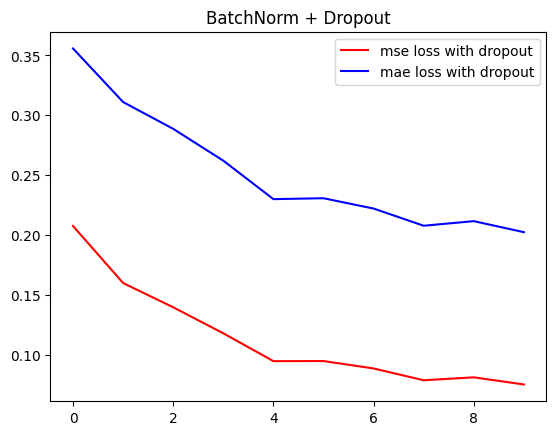

In [33]:
plt.plot(np.array(mse_loss_cnn_with_dropout), color='r', label='mse loss with dropout')
plt.plot(np.array(mae_loss_cnn_with_dropout), color='b', label='mae loss with dropout')
plt.legend()
plt.title('BatchNorm + Dropout')
plt.show()

## Вывод пункта А
Какой эксперимент: Добавление Батчнорма и/или Дропаута

Бейзлайн: моедль с 3 линейными слоями, с двумя параллельными свертками, с нуля обучающиеся эмбеды размера 300

Итог: Лучше всего показала себя бейзлайн модель с Mean square error: 0.06764, Mean absolute error: 0.19327. В модели с Батчнормом Mean square error: 0.10677, Mean absolute error: 0.25489. Батчнорм + Дропаут Mean square error: 0.07513, Mean absolute error: 0.20233

Обучение: 10 эпох, 20 размер батча, с сгд оптимайзером

#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

In [34]:
embed_len = 300


class EncoderModifiedPooling(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embed_len)
        self.conv1 = nn.Conv1d(embed_len, hid_size, kernel_size=(3,))
        self.attn = nn.Linear(hid_size, 1)

    def forward(self, matrix):
        matrix = self.conv1(self.emb(matrix).swapaxes(1, 2))
        emb_max_pool = torch.max(matrix, dim=-1).values
        emb_avg_pool = torch.mean(matrix, dim=-1)
        emb_softmax_pool = torch.sum(matrix * torch.softmax(matrix, dim=-1), dim=-1)
        
        matrix = matrix.swapaxes(1, 2)
        attn_weights = self.attn(matrix)
        emb_attn_pool = torch.sum(matrix * torch.softmax(attn_weights, dim=1), dim=1)

        return torch.cat((emb_max_pool, emb_avg_pool, emb_softmax_pool, emb_attn_pool), 1)
        #return emb1

In [35]:
class SalaryPredictorModifiedPooling(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderModifiedPooling(n_tokens, hid_size)
        self.description_enc = EncoderModifiedPooling(n_tokens, hid_size)
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.fc1 = nn.Linear(9 * hid_size, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return torch.squeeze(x)

In [36]:
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_modified_pooling= SalaryPredictorModifiedPooling().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_modified_pooling.parameters(), lr=1e-4)

mse_loss_modified_pooling = []
mae_loss_modified_pooling = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_modified_pooling.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_modified_pooling(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_modified_pooling, data_val, device=device)
    mse_loss_modified_pooling.append(mse)
    mae_loss_modified_pooling.append(mae)


epoch: 0


9791it [01:38, 99.54it/s]                           


 results:
Mean square error: 0.30296
Mean absolute error: 0.47087
epoch: 1


9791it [01:35, 102.17it/s]                          


 results:
Mean square error: 0.11122
Mean absolute error: 0.25774
epoch: 2


9791it [01:39, 98.20it/s]                           


 results:
Mean square error: 0.09273
Mean absolute error: 0.22973
epoch: 3


9791it [01:40, 97.46it/s]                           


 results:
Mean square error: 0.08596
Mean absolute error: 0.21956
epoch: 4


9791it [01:39, 98.03it/s]                           


 results:
Mean square error: 0.15841
Mean absolute error: 0.32278
epoch: 5


9791it [01:38, 99.12it/s]                           


 results:
Mean square error: 0.08424
Mean absolute error: 0.21902
epoch: 6


9791it [01:36, 101.48it/s]                          


 results:
Mean square error: 0.07686
Mean absolute error: 0.20583
epoch: 7


9791it [01:37, 100.56it/s]                          


 results:
Mean square error: 0.07546
Mean absolute error: 0.20375
epoch: 8


9791it [01:38, 99.73it/s]                           


 results:
Mean square error: 0.07467
Mean absolute error: 0.20342
epoch: 9


9791it [01:35, 102.50it/s]                          


 results:
Mean square error: 0.07296
Mean absolute error: 0.20078


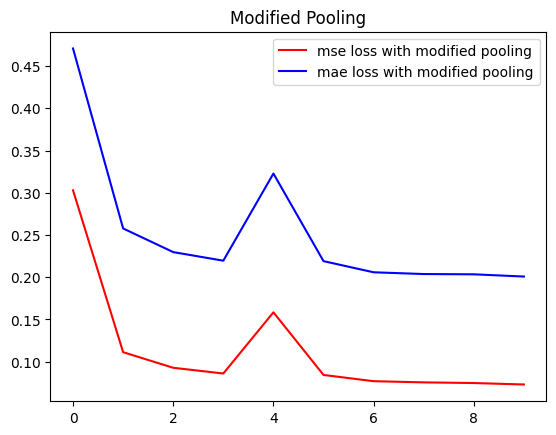

In [37]:
plt.plot(np.array(mse_loss_modified_pooling), color='r', label='mse loss with modified pooling')
plt.plot(np.array(mae_loss_modified_pooling), color='b', label='mae loss with modified pooling')
plt.legend()
plt.title('Modified Pooling')
plt.show()

In [40]:
embed_len = 300


class EncoderMoreAttentive(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embed_len)
        self.conv1 = nn.Conv1d(embed_len, hid_size, kernel_size=(3,))
        self.attn1 = nn.Linear(hid_size, 1)
        self.attn2 = nn.Linear(hid_size, 1)
        self.attn3 = nn.Linear(hid_size, 1)

    def forward(self, matrix):
        matrix = self.conv1(self.emb(matrix).swapaxes(1, 2))
        emb_max_pool = torch.max(matrix, dim=-1).values
        emb_avg_pool = torch.mean(matrix, dim=-1)
        emb_softmax_pool = torch.sum(matrix * torch.softmax(matrix, dim=-1), dim=-1)
        
        matrix = matrix.swapaxes(1, 2)
        
        attn_weights1 = self.attn1(matrix)
        emb_attn_pool1 = torch.sum(matrix * torch.softmax(attn_weights1, dim=1), dim=1)
        
        attn_weights2 = self.attn2(matrix)
        emb_attn_pool2 = torch.sum(matrix * torch.softmax(attn_weights2, dim=1), dim=1)
        
        attn_weights3 = self.attn3(matrix)
        emb_attn_pool3 = torch.sum(matrix * torch.softmax(attn_weights3, dim=1), dim=1)

        return torch.cat((emb_max_pool, emb_avg_pool, emb_softmax_pool, emb_attn_pool1, emb_attn_pool2, emb_attn_pool3), 1)
        #return emb1
        
        
class SalaryPredictorMoreAttentive(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderMoreAttentive(n_tokens, hid_size)
        self.description_enc = EncoderMoreAttentive(n_tokens, hid_size)
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.fc1 = nn.Linear(13 * hid_size, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return torch.squeeze(x)

In [41]:
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_more_attentive = SalaryPredictorMoreAttentive().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_more_attentive.parameters(), lr=1e-4)

mse_loss_more_attentive = []
mae_loss_more_attentive = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_more_attentive.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_more_attentive(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_more_attentive, data_val, device=device)
    mse_loss_more_attentive.append(mse)
    mae_loss_more_attentive.append(mae)


epoch: 0


9791it [01:51, 87.88it/s]                          


 results:
Mean square error: 0.13044
Mean absolute error: 0.28086
epoch: 1


9791it [01:52, 87.42it/s]                          


 results:
Mean square error: 0.11960
Mean absolute error: 0.26990
epoch: 2


9791it [01:50, 88.24it/s]                          


 results:
Mean square error: 0.09286
Mean absolute error: 0.22864
epoch: 3


9791it [01:49, 89.65it/s]                          


 results:
Mean square error: 0.09046
Mean absolute error: 0.22568
epoch: 4


9791it [01:49, 89.12it/s]                          


 results:
Mean square error: 0.12572
Mean absolute error: 0.27869
epoch: 5


9791it [01:47, 91.49it/s]                          


 results:
Mean square error: 0.08036
Mean absolute error: 0.21386
epoch: 6


9791it [01:50, 88.89it/s]                          


 results:
Mean square error: 0.07507
Mean absolute error: 0.20509
epoch: 7


9791it [01:49, 89.35it/s]                          


 results:
Mean square error: 0.07608
Mean absolute error: 0.20768
epoch: 8


9791it [01:49, 89.65it/s]                          


 results:
Mean square error: 0.07236
Mean absolute error: 0.19963
epoch: 9


9791it [01:48, 90.35it/s]                          


 results:
Mean square error: 0.06922
Mean absolute error: 0.19447


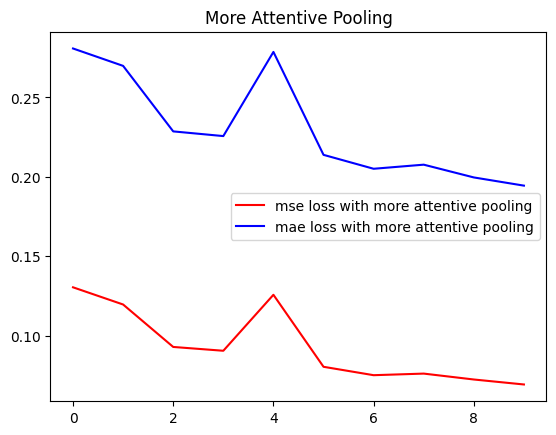

In [43]:
plt.plot(np.array(mse_loss_more_attentive), color='r', label='mse loss with more attentive pooling')
plt.plot(np.array(mae_loss_more_attentive), color='b', label='mae loss with more attentive pooling')
plt.legend()
plt.title('More Attentive Pooling')
plt.show()

## Вывод пункта В
Какой эксперимент: Добавление нескольких attentive пуллингов

Бейзлайн: модель с 3 линейными слоями, с одной свертками, с нуля обучающиеся эмбеды размера 300, макс пуллинг, mean пуллинг, софтмакс пуллинг и attentive пуллинг

Итог: Бейзлайн модель Mean square error: 0.07296, Mean absolute error: 0.20078. В модели, где в бейзлайн добавил еще 2 attentive пуллинга: Mean square error: 0.06922, Mean absolute error: 0.19447

Обучение: 10 эпох, 20 размер батча, с сгд оптимайзером

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer

In [20]:
import gensim.downloader
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [21]:
token_embeds = []
embed_len = 300

for token in tokens:
    try:
        token_embeds.append(embeddings.get_vector(token))
    except Exception:
        token_embeds.append(np.random.normal(size=embed_len))

token_embeds_np = np.array(token_embeds)
embed_weights = torch.tensor(token_embeds_np, device=device, dtype=torch.float)

In [28]:
embed_len = 300


class EncoderWV(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embed_len)
        self.emb.weight = nn.Parameter(embed_weights, requires_grad=True)
        self.conv1 = nn.Conv1d(embed_len, hid_size, kernel_size=(3,))
        self.conv2 = nn.Conv1d(embed_len, hid_size, kernel_size=(2,))

    def forward(self, matrix):
        emb1 = self.conv1(self.emb(matrix).swapaxes(1, 2)).max(dim=-1).values
        emb2 = self.conv2(self.emb(matrix).swapaxes(1, 2)).max(dim=-1).values

        return torch.cat((emb1, emb2), 1)

    
class SalaryPredictorWV(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_enc = EncoderWV(n_tokens, embed_len)
        self.description_enc = EncoderWV(n_tokens, embed_len)
        
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, 32),
            nn.ReLU(),
            nn.Linear(32, hid_size)
        )
        self.fc1 = nn.Linear(hid_size + 4 * embed_len, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, batch):
        title = self.title_enc(batch['Title'])
        description = self.description_enc(batch['FullDescription'])
        cat = self.cat_enc(batch['Categorical'])
        x = torch.cat((title, description, cat), 1)

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return torch.squeeze(x)

In [29]:
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wv = SalaryPredictorWV().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_wv.parameters(), lr=1e-4)

mse_loss_wv = []
mae_loss_wv = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_wv.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_wv(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model_wv, data_val, device=device)
    mse_loss_wv.append(mse)
    mae_loss_wv.append(mae)


epoch: 0


9791it [03:16, 49.80it/s]                          


 results:
Mean square error: 0.14909
Mean absolute error: 0.30546
epoch: 1


9791it [03:21, 48.61it/s]                          


 results:
Mean square error: 0.11088
Mean absolute error: 0.25547
epoch: 2


9791it [03:21, 48.70it/s]                          


 results:
Mean square error: 0.10182
Mean absolute error: 0.24339
epoch: 3


9791it [03:21, 48.48it/s]                          


 results:
Mean square error: 0.09187
Mean absolute error: 0.22669
epoch: 4


9791it [03:21, 48.70it/s]                          


 results:
Mean square error: 0.08860
Mean absolute error: 0.22179
epoch: 5


9791it [03:20, 48.91it/s]                          


 results:
Mean square error: 0.08582
Mean absolute error: 0.21868
epoch: 6


9791it [03:18, 49.28it/s]                          


 results:
Mean square error: 0.08488
Mean absolute error: 0.21641
epoch: 7


9791it [03:20, 48.94it/s]                          


 results:
Mean square error: 0.08620
Mean absolute error: 0.22076
epoch: 8


9791it [03:19, 49.04it/s]                          


 results:
Mean square error: 0.08356
Mean absolute error: 0.21474
epoch: 9


9791it [03:19, 49.10it/s]                          


 results:
Mean square error: 0.08033
Mean absolute error: 0.21032


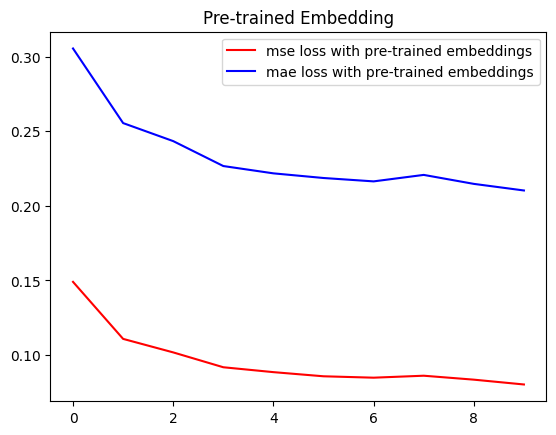

In [30]:
plt.plot(np.array(mse_loss_wv), color='r', label='mse loss with pre-trained embeddings')
plt.plot(np.array(mae_loss_wv), color='b', label='mae loss with pre-trained embeddings')
plt.legend()
plt.title('Pre-trained Embedding')
plt.show()

## Вывод пункта C
Какой эксперимент: Добавление предобученных эмбеддингов

Бейзлайн: такая же как в пункте А

Итог: Бейзлайн модель Mean square error: 0.06764, Mean absolute error: 0.19327. В модели, где добавил фасттекст: Mean square error: 0.08033
Mean absolute error: 0.21032

Обучение: 10 эпох, 20 размер батча, с сгд оптимайзером

### A short report

Please tell us what you did and how did it work.

По итогу по эксперементировал с добавлением Батчнорм/Дропаут, с пуллингами и предобученными эмбеддингами. Лучше всего показала себя модель с двумя параллельными свертками

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!